In [23]:
import numpy as np
import matplotlib.pyplot as plt

def aperiodic_first_por(k:int,factors:list, omega:list):
    real_magnitude_db   = np.zeros_like(omega, dtype=float)
    approx_magnitude_db = np.zeros_like(omega, dtype=float)
    angel               = np.zeros_like(omega, dtype=float)

    for (T) in factors:
        factor_magnitude = k / np.sqrt(1 + (T*omega)**2)
        factor_magnitude_db =   20 * np.log10(factor_magnitude)

        omega_break = 1.0 / T
        below_break = (omega < omega_break)
        above_break = ~below_break

        factor_approx_db = np.zeros_like(omega)

        factor_approx_db[below_break] = 20 * np.log10(k)

        factor_approx_db[above_break] = 20 * np.log10(k) - 20 * np.log10(T*omega[above_break])

        real_magnitude_db   += factor_magnitude_db
        approx_magnitude_db += factor_approx_db
        angel               += -np.arctan(T*omega)

    return np.array([real_magnitude_db, approx_magnitude_db,angel])

def forsiruyochie_first_por(k:int,factors:list, omega:list):
    real_magnitude_db   = np.zeros_like(omega, dtype=float)
    approx_magnitude_db = np.zeros_like(omega, dtype=float)
    angel               = np.zeros_like(omega, dtype=float)

    for (T) in factors:
        factor_magnitude    = k * np.sqrt(1 + (T*omega)**2)
        factor_magnitude_db = 20 * np.log10(factor_magnitude)

        omega_break = 1.0 / T
        below_break = (omega < omega_break)
        above_break = ~below_break

        factor_approx_db = np.zeros_like(omega)
        factor_approx_db[below_break] = 20 * np.log10(k)

        factor_approx_db[above_break] = 20 * np.log10(k) + 20 * np.log10(T*omega[above_break])

        real_magnitude_db   += factor_magnitude_db
        approx_magnitude_db += factor_approx_db
        angel               += np.arctan(T*omega)

    return np.array([real_magnitude_db, approx_magnitude_db,angel])

def integriruyouchie(k:int,factors:list, omega:list):
    real_magnitude_db   = np.zeros_like(omega, dtype=float)
    approx_magnitude_db = np.zeros_like(omega, dtype=float)
    angel               = np.zeros_like(omega, dtype=float)

    for (T) in factors:
        factor_magnitude    = k / (omega*T)
        factor_magnitude_db = 20 * np.log10(factor_magnitude)

        factor_approx_db = factor_magnitude_db

        real_magnitude_db   += factor_magnitude_db
        approx_magnitude_db += factor_approx_db
        angel               += - np.pi / 2

    return np.array([real_magnitude_db, approx_magnitude_db,angel])

def colebatelbnoe(k: int, factors: list, omega: list, psi: int):
    real_magnitude_db   = np.zeros_like(omega, dtype=float)
    approx_magnitude_db = np.zeros_like(omega, dtype=float)
    angel               = np.zeros_like(omega, dtype=float)

    for _, T in enumerate(factors):  # Убираем лишние скобки вокруг T
        factor_magnitude = k / np.sqrt(((1-T**2*omega**2)**2 + (2*psi*T*omega)**2))
        factor_magnitude_db = 20 * np.log10(factor_magnitude)

        omega_break = 1.0 / T
        below_break = (omega < omega_break)
        above_break = ~below_break

        factor_approx_db = np.zeros_like(omega)
        factor_approx_db[below_break] = 20 * np.log10(k)
        factor_approx_db[above_break] = 20 * np.log10(k) - 20 * np.log10(T**2*omega[above_break]**2)

        angel[below_break]  += -np.arctan((2*psi*T*omega[below_break])/(1-T**2*omega[below_break]))
        angel[above_break]  += -np.arctan((2*psi*T*omega[above_break])/(1-T**2*omega[above_break])) - np.pi
        real_magnitude_db   += factor_magnitude_db
        approx_magnitude_db += factor_approx_db

    return np.array([real_magnitude_db, approx_magnitude_db,angel])

def differenciruchee(k: int, factors: list, omega: list):
    real_magnitude_db   = np.zeros_like(omega, dtype=float)
    approx_magnitude_db = np.zeros_like(omega, dtype=float)
    angel               = np.zeros_like(omega, dtype=float)

    for _, T in enumerate(factors):  # Убираем лишние скобки вокруг T
        factor_magnitude = k * omega
        factor_magnitude_db = 20 * np.log10(factor_magnitude)

        omega_break = 1.0 / T
        below_break = (omega < omega_break)
        above_break = ~below_break

        factor_approx_db = np.zeros_like(omega) # not property work
        factor_approx_db[below_break] = 20 * np.log10(k)# not property work
        factor_approx_db[above_break] = 20 * np.log10(k) - 20 * np.log10(T**2*omega[above_break]**2)# not property work

        angel[below_break]  += np.pi / 2
        angel[above_break]  += np.pi / 2
        real_magnitude_db   += factor_magnitude_db
        approx_magnitude_db += factor_approx_db

    return np.array([real_magnitude_db, approx_magnitude_db,angel])


W(p) = ((0.1p+1)*((5p+1)^2)) / (49*(p^2)*(0.04p^2 +0.04p +1))

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import TransferFunction, bode
start_log = -2
end_log   = 2
separates = 1000
psi       = 0.1

omega = np.logspace(start_log, end_log, separates)  # от 0.01 до 100 рад/с

# Типовые звенья:
# - (0.1p+1): угол частоты w_z = 1/0.1 = 10 рад/с
# - (5p+1)^2: дважды одно и то же звено с w1=1/5=0.2 рад/с
# - 7^2*p^2 в знаменателе: это -40 дБ/декаду наклон после низких частот
# - (0.04p^2 +0.2p +1) примерно колебательное звено с ω_n = 5 рад/с, ζ=0.1

# Построим асимптотическую ЛАЧХ:
# L_omega_as = (    colebatelbnoe          (k=1, factors=([0.2]),omega=omega, psi=psi)
#               + 2*forsiruyochie_first_por(k=1, factors=([5]),  omega=omega)
#               +   forsiruyochie_first_por(k=1, factors=([0.1]),omega=omega)
#               + 2*integriruyouchie       (k=1, factors=([7]),  omega=omega)
#               )
L_omega_as =  colebatelbnoe          (k=1, factors=([0.2]),omega=omega, psi=psi)+ \
              forsiruyochie_first_por(k=1, factors=([5,5,0.1]),  omega=omega)+ \
              integriruyouchie       (k=1, factors=([7,7]),  omega=omega)


# plt.figure(figsize=(12, 12))

# # ЛАЧХ
# plt.subplot(2,1,1)
# plt.semilogx(omega, colebatelbnoe(k=1, factors=([0.2]),omega=omega, psi=psi)[0], '--', label='Колебательные ЛАЧХ',linewidth=0.5)
# plt.semilogx(omega, forsiruyochie_first_por(k=1, factors=([5,5,0.1]),  omega=omega)[0], '--', label='Форсирующые ЛАЧХ',linewidth=0.5)
# plt.semilogx(omega, integriruyouchie       (k=1, factors=([7,7]),  omega=omega)[0], '--', label='Интегрирующые ЛАЧХ',linewidth=0.5)
# plt.semilogx(omega, L_omega_as[0], label='Сумма ЛАЧХ')
# plt.semilogx(omega, L_omega_as[1], label='Сумма  апроксимирующей ЛАЧХ')
# plt.title("ЛАЧХ")
# plt.xlabel('ω, рад/с')
# plt.ylabel('Амплитуда, дБ')
# plt.grid(True)
# plt.legend()

# # # ЛФЧХ
# plt.subplot(2,1,2)
# plt.semilogx(omega, colebatelbnoe(k=1, factors=([0.2]),omega=omega, psi=psi)[2], '--', label='Колебательные ЛфЧХ',linewidth=0.7)
# plt.semilogx(omega, forsiruyochie_first_por(k=1, factors=([5,5,0.1]),  omega=omega)[2], '--', label='Форсирующие ЛфЧХ',linewidth=0.7)
# plt.semilogx(omega, integriruyouchie       (k=1, factors=([7,7]),  omega=omega)[2], '--', label='Интегрирующие ЛфЧХ',linewidth=0.7)

# plt.semilogx(omega, L_omega_as[2], label='Сумма ЛФЧХ')
# plt.title("ЛФЧХ")
# plt.xlabel('ω, рад/с')
# plt.ylabel('Фаза, рад')
# plt.grid(True)
# plt.legend()

# plt.tight_layout()
# plt.show()


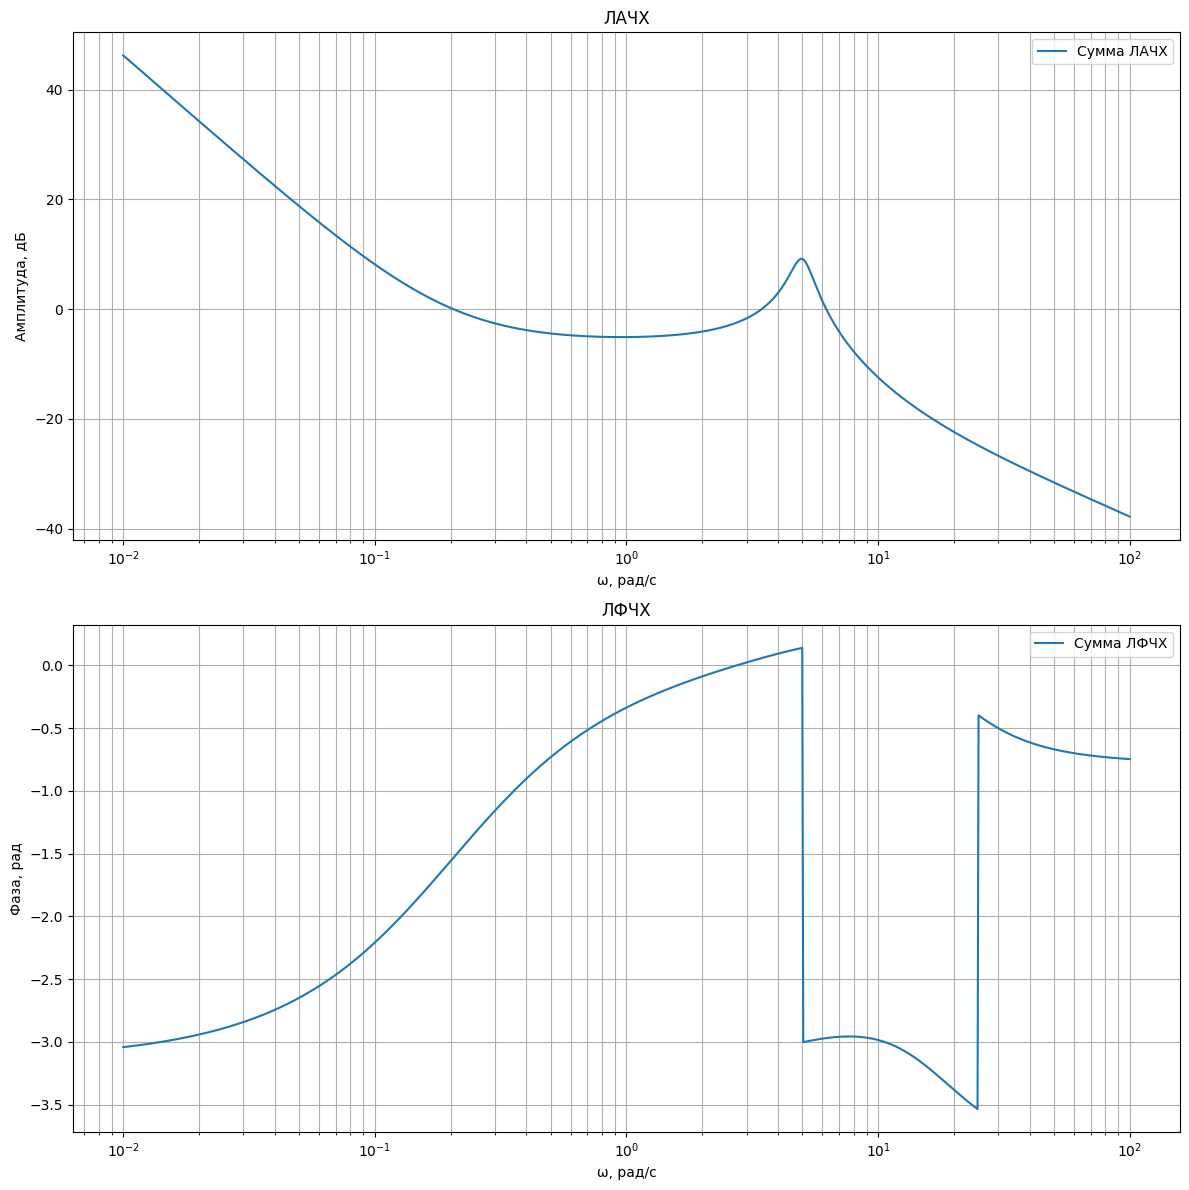

In [25]:
plt.figure(figsize=(12, 12))
# ЛАЧХ
plt.subplot(2,1,1)
# plt.semilogx(omega, colebatelbnoe(k=1, factors=([0.2]),omega=omega, psi=psi)[0], '--', label='Колебательные ЛАЧХ',linewidth=0.5)
# plt.semilogx(omega, forsiruyochie_first_por(k=1, factors=([5,5,0.1]),  omega=omega)[0], '--', label='Форсирующые ЛАЧХ',linewidth=0.5)
# plt.semilogx(omega, integriruyouchie       (k=1, factors=([7,7]),  omega=omega)[0], '--', label='Интегрирующые ЛАЧХ',linewidth=0.5)
plt.semilogx(omega, L_omega_as[0], label='Сумма ЛАЧХ')

# plt.semilogx(omega, L_omega_as[1], label='Сумма  апроксимирующей ЛАЧХ')
plt.title("ЛАЧХ")
plt.xlabel('ω, рад/с')
plt.ylabel('Амплитуда, дБ')
plt.grid(True, which='both')
plt.legend()

# # ЛФЧХ
plt.subplot(2,1,2)
# plt.semilogx(omega, colebatelbnoe(k=1, factors=([0.2]),omega=omega, psi=psi)[2], '--', label='Колебательные ЛфЧХ',linewidth=0.7)
# plt.semilogx(omega, forsiruyochie_first_por(k=1, factors=([5,5,0.1]),  omega=omega)[2], '--', label='Форсирующие ЛфЧХ',linewidth=0.7)
# plt.semilogx(omega, integriruyouchie       (k=1, factors=([7,7]),  omega=omega)[2], '--', label='Интегрирующие ЛфЧХ',linewidth=0.7)

plt.semilogx(omega, L_omega_as[2], label='Сумма ЛФЧХ')
plt.title("ЛФЧХ")
plt.xlabel('ω, рад/с')
plt.ylabel('Фаза, рад')
plt.grid(True, which='both')
plt.legend()

plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

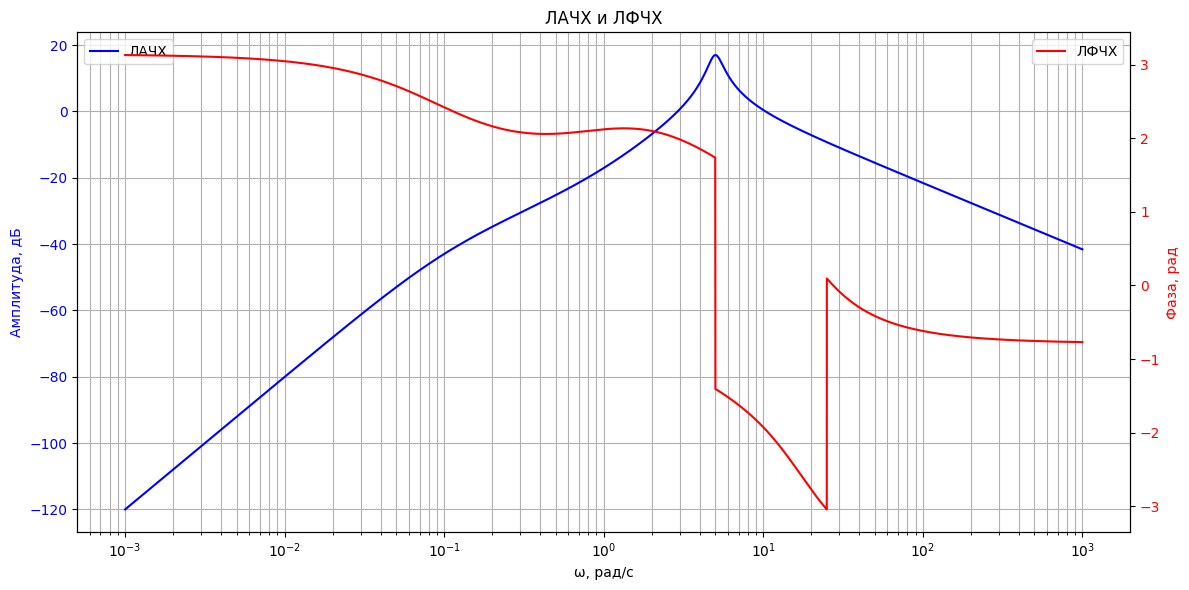

In [26]:

start_log = -3
end_log   = 3
separates = 10000
psi       = 0.1
omega = np.logspace(start_log, end_log, separates)  # от 0.01 до 100 рад/с

# Типовые звенья:
# - (0.1p+1): угол частоты w_z = 1/0.1 = 10 рад/с
# - (5p+1)^2: дважды одно и то же звено с w1=1/5=0.2 рад/с
# - 7^2*p^2 в знаменателе: это -40 дБ/декаду наклон после низких частот
# - (0.04p^2 +0.2p +1) примерно колебательное звено с ω_n = 5 рад/с, ζ=0.1

# Построим асимптотическую ЛАЧХ:
# L_omega_as = (    colebatelbnoe          (k=1, factors=([0.2]),omega=omega, psi=psi)
#               + 2*forsiruyochie_first_por(k=1, factors=([5]),  omega=omega)
#               +   forsiruyochie_first_por(k=1, factors=([0.1]),omega=omega)
#               + 2*integriruyouchie       (k=1, factors=([7]),  omega=omega)
#               )
L_omega_as =  colebatelbnoe          (k=1, factors=([0.2]),omega=omega, psi=psi)+ \
              forsiruyochie_first_por(k=1, factors=([1]),  omega=omega)+ \
              aperiodic_first_por    (k=1, factors=([10,0.3]),omega=omega) + \
              differenciruchee       (k=1, factors=([1,1]),omega=omega)


plt.figure(figsize=(12, 6))

# Создаем основную ось
fig, ax1 = plt.subplots(figsize=(12, 6))

# График ЛАЧХ (Амплитуда, дБ)
ax1.semilogx(omega, L_omega_as[0], label='ЛАЧХ', color='blue')
ax1.set_title("ЛАЧХ и ЛФЧХ")
ax1.set_xlabel('ω, рад/с')
ax1.set_ylabel('Амплитуда, дБ', color='blue')
ax1.grid(True, which='both')
ax1.legend(loc='upper left')
ax1.tick_params(axis='y', labelcolor='blue')

# Создаем вторую ось для ЛФЧХ (Фаза, рад)
ax2 = ax1.twinx()
ax2.semilogx(omega, L_omega_as[2], label='ЛФЧХ', color='red')
ax2.set_ylabel('Фаза, рад', color='red')
ax2.legend(loc='upper right')
ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.show()
